In [2]:
import os
import pickle
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

import itertools
from scipy.stats import pearsonr

import sys
sys.path.insert(1, '../cell2cell/')
import cell2cell as c2c
from cell2cell.tensor.tensor import BaseTensor
from cell2cell.tensor.factorization import _compute_norm_error

sys.path.insert(1, '../c2c_sim/')
from core.simulate import Simulate, CCI_MD


# specify path to save figures
fig_path = ''#'/data2/hratch/cci_dt/figures/'
data_path = ''#'/data2/hratch/cci_dt/noise_v_error/'
version = 1

/home/hratch/anaconda3/envs/cci_dt/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# Generate Simulated Tensor

In [8]:
# init
sim = Simulate() 

# simulate a scale_free randomly connected ligand-receptor network (potential interactions)
sim.LR_network(network_type = 'scale-free', **{'nodes': 100, 'degrees': 3, 'alpha': 2}) #scale-free
print('{} ligands, {} receptors, and {} edges'.format(len(sim.LR.ligands), len(sim.LR.receptors), 
                                                      len(sim.LR.edge_list)))

# LR metadata
sim.LR.generate_metadata(n_LR_cats = {3: 0}, cat_skew = 0)

# generate cell metadata, accounting for directionality (senders vs receivers) and 
# allowing for autocrine interactions 
cci = CCI_MD()
cci.cci_network(n_cells = 50, directional = True, autocrine = True)

# generate 1 metadata categories, with 3 subcategories and 0 skew, the overall skew of categories is 0
# do not remove homotypic interactions (will be included)
cci.generate_metadata(n_cell_cats = {3: 0}, cat_skew = 0, remove_homotypic = 0)
# add cell metadata to simulation object
sim.cci = cci

# generate n_patter metadata groups of CC-LR pairs that change across n_conditions
# these changes can either be linear, oscillating, or a pulse; allow homotypic interactions to form patterns
# maximize the possible change in communication score
sim.generate_tensor_md(n_patterns = 4, n_conditions = 12, patterns = ['pulse', 'linear', 'oscillate', 'power'], 
                      consider_homotypic = True, score_change = 'max')

#generate a tensor with continuous LR scores and baseline noise; keep single-cells 
sim.generate_tensor(noise = 0.01, binary = False, bulk = True, noise_max = 0.05)

# format the tensor to be input to tensor-cell2cell
sim.reshape()

/home/hratch/Projects/c2c_sim/explore/tmp9dnvw1in_bipartite_sf.csv
Generate undirected, bipartite, scale-free graph
Check network properties
All properties are as expected
71 ligands, 62 receptors, and 300 edges


../c2c_sim/core/graphs.py:164: UserWarning: 67 nodes are disconnected, removing from network
  warnings.warn(mssg)
/home/hratch/anaconda3/envs/cci_dt/lib/python3.9/site-packages/pandas/core/internals/blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
../c2c_sim/core/simulate.py:724: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df.values[coords] = vals
  0%|          | 0/12 [00:00<?, ?it/s]../c2c_sim/core/simulate.py:759: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated;

Generate reshaped tensor


100%|██████████| 12/12 [00:00<00:00, 22.50it/s]


In [22]:
sim.sim_tensor.tensor_cci.shape

(12, 300, 3, 3)

In [ ]:
sim.pickle(data_path + 'sim_obj_v' + str(version) + '.pickle')

In [9]:
tensor = BaseTensor()
t1 = sim.sim_tensor.tensor_cci
tensor.tensor = t1
tensor.order_names = [['Context-{}'.format(c+1) for c in range(t1.shape[0])],
                      ['LR-{}'.format(c+1) for c in range(t1.shape[1])],
                      ['Sender-{}'.format(c+1) for c in range(t1.shape[2])],
                      ['Receiver-{}'.format(c+1) for c in range(t1.shape[3])]
                     ]

  0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 288x162 with 1 Axes>,
 [(1, 0.7715065964247386),
  (2, 0.5682070476296172),
  (3, 0.32628833921994993),
  (4, 0.00958827024353051),
  (5, 0.32628900076174505)])

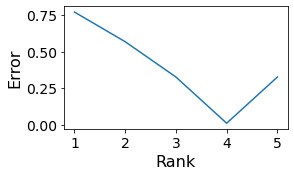

In [10]:
tensor.elbow_rank_selection(5)

In [ ]:
tensor.compute_tensor_factorization(rank=4)
with open(data_path + 'tensor_obj_v' + str(version) + '.pickle', 'wb') as f:
    pickle.dump(tensor, f)

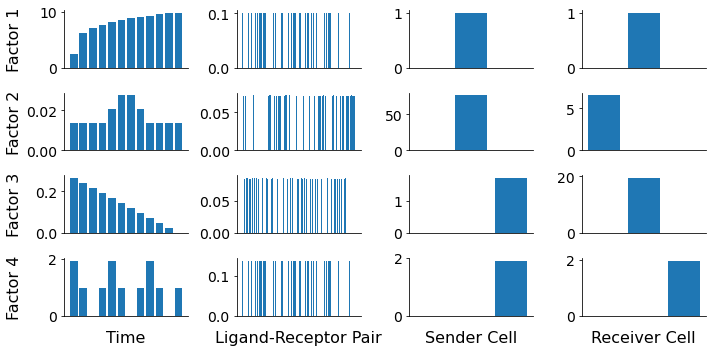

In [15]:
fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                             order_labels=['Time', 'Ligand-Receptor Pair', 'Sender Cell', 'Receiver Cell'],
                                             #metadata = tensor.order_names,
                                             #sample_col='Order',
                                             #group_col='Element',
                                             #meta_cmaps=['viridis', 'tab20', 'Pastel1', 'Pastel1'],
                                             fontsize=14,
                                             filename=fig_path + 'TF_SIM_v' + str(version) + '.pdf'
                                            )
plt.close()

fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                             order_labels=['Time', 'Ligand-Receptor Pair', 'Sender Cell', 'Receiver Cell'],
                                             #metadata = tensor.order_names,
                                             #sample_col='Order',
                                             #group_col='Element',
                                             #meta_cmaps=['viridis', 'tab20', 'Pastel1', 'Pastel1'],
                                             fontsize=14,
                                             filename=fig_path + 'TF_SIM_v' + str(version) + '.png'
                                            )

../c2c_sim/core/simulate.py:818: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res_['score'] = self.ts[cond].values[self.clrm.loc[cat,'ts_coordinates']]
../c2c_sim/core/simulate.py:824: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res_['score'] = self.ts['0'].values[background_coords]


Generate graph


../c2c_sim/core/simulate.py:865: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(file_name, bbox_to_inches = 'tight')
../c2c_sim/core/simulate.py:818: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res_['score'] = self.ts[cond].values[self.clrm.loc[cat,'ts_coordinates']]
../c2c_sim/core/simulate.py:824: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res_['score'] = self.ts['0'].values[background_coo

Generate graph


../c2c_sim/core/simulate.py:865: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(file_name, bbox_to_inches = 'tight')


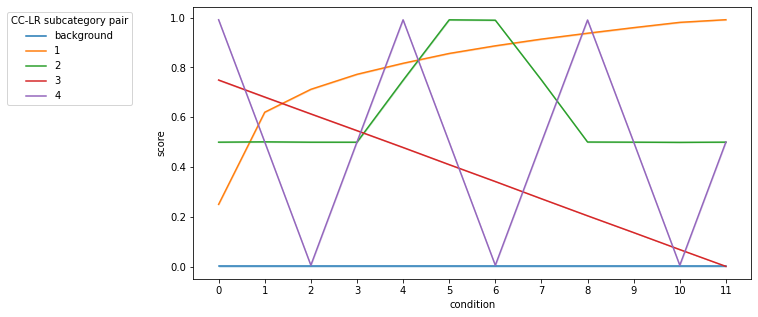

In [20]:
sim.visualize(background_coords=sim.get_background(), file_name=fig_path + 'actual_values_pattern.pdf')
plt.close()
sim.visualize(background_coords=sim.get_background(), file_name=fig_path + 'actual_values_pattern.png')

# Accuracy

In [ ]:
def get_jaccard(list1,list2):
    num = len(set(list1).intersection(list2))
    denom = len(set(list1).union(list2))
    return num/denom
# with open(data_path + 'tensor_obj_v' + str(version) + '.pickle', 'rb') as f:
#     tensor = pickle.load(f)
# with open(data_path + 'sim_obj_v' + str(version) + '.pickle', 'rb') as f:
#     sim = pickle.load(f)

In [35]:
lr_factors = tensor.tl_object.factors[1]

In [ ]:
fig, ax = plt.subplots(ncols = lr_factors.shape[1], figsize = (15,4))
colors = sns.color_palette("tab10")[:4]


counter = 0
for factor in range(lr_factors.shape[1]):
    loadings = lr_factors[:,factor]
    sns.distplot(loadings, kde = False, ax = ax[counter], color = colors[counter])
    if counter == 0:
        ax[counter].set_ylabel('Count')
    else:
        ax[counter].set_ylabel('')
    ax[counter].set_xlabel('Loadings')
    ax[counter].set_title('Factor {}'.format(factor + 1))
    
    counter += 1
plt.subplots_adjust(wspace = 0.2)
plt.savefig(fig_path + 'LR_loading_distributions.pdf', bbox_to_inches = 'tight')
plt.savefig(fig_path + 'LR_loading_distributions.png', bbox_to_inches = 'tight')

In [161]:
# get the IDs of the assigned LR pairs for each of the 4 patterns
assigned_lrs = dict()
senders = dict()
receivers = dict()
for idx in sim.clrm.index:
    pattern = sim.clrm.loc[idx, 'pattern']
    assigned = sim.clrm.loc[idx, ['cell_subcat', 'LR_subcat']]
    assigned_lrs[pattern] = sim.LR.LR_metadata[sim.LR.LR_metadata.subcategory == assigned.LR_subcat].LR_id.tolist()
    senders[pattern] = [assigned.cell_subcat[0]]
    receivers[pattern] = [assigned.cell_subcat[1]]
    
# binarize the LR loadings for each factor and get the LR IDs for those with 1 (high loadings)
decomposed_lrs = dict()
for factor in range(lr_factors.shape[1]):
    binarized_lr_loadings = pd.cut(lr_factors[:,factor], bins = 2, labels = [0,1]).tolist()
    decomposed_lrs[factor + 1] = [sim.sim_tensor.lr_labels[i] for i in range(len(binarized_lr_loadings)) if binarized_lr_loadings[i] == 1]

jaccards = pd.DataFrame(columns = ['factor - loadings', 'pattern - assigned', 'Jaccard index'])
counter = 0
for factor in decomposed_lrs:
    for pattern in assigned_lrs:
        jaccards.loc[counter, :] = [factor, pattern, get_jaccard(decomposed_lrs[factor], assigned_lrs[pattern])]
        counter += 1
jaccards['pattern - assigned'] = jaccards['pattern - assigned'].replace('power', 'exponential')
jaccards.to_csv(data_path + 'LR_Jaccard.csv')

In [213]:
lr_idx_map = {id_: idx for idx,id_ in enumerate(sim.sim_tensor.lr_labels)}
sender_idx_map = {id_: idx for idx,id_ in enumerate(sim.sim_tensor.senders)}
receiver_idx_map = {id_: idx for idx,id_ in enumerate(sim.sim_tensor.receivers)}

# assigned_lrs_idx = {k: [lr_idx_map[i] for i in v] for k,v in assigned_lrs.items()}
# senders_idx = {k: [sender_idx_map[i] for i in v] for k,v in senders.items()}
# receivers_idx = {k: [receiver_idx_map[i] for i in v] for k,v in receivers.items()}

In [268]:
res = pd.DataFrame(columns = ['factor', 'assigned_pattern', 'loadings', 'communication_score_variance'])
factor = 1
pattern = 'pulse'

for factor in range(lr_factors.shape[1]):
    for pattern in sim.clrm.pattern.unique():
        res_ = pd.DataFrame(data = {'loadings': lr_factors[:,factor]}, index = sim.sim_tensor.lr_labels)
        lr_idx = [lr_idx_map[i] for i in assigned_lrs[pattern]]
        sender_idx = [sender_idx_map[i] for i in senders[pattern]]
        receiver_idx = [receiver_idx_map[i] for i in receivers[pattern]]

        variances = list()
        for lr_i in range((sim.sim_tensor.tensor_cci.shape[1])):#lr_idx:
            variances.append(np.var(sim.sim_tensor.tensor_cci[:, lr_i,sender_idx,receiver_idx].flatten()))
        res_['communication_score_variance'] = variances
        res_['factor'] = factor + 1
        res_['assigned_pattern'] = pattern

        res_ = res_[['factor', 'assigned_pattern', 'loadings', 'communication_score_variance']]
        res = pd.concat([res, res_])


In [321]:
res_stats = pd.DataFrame(columns = ['factor', 'assigned_pattern', 'Pearson r', 'p-value'])
counter = 0
for factor, pattern in itertools.product(res.factor.unique(), res.assigned_pattern.unique()):
    res_ = res[(res.factor == factor) & (res.assigned_pattern == pattern)]
    r = pearsonr(res_.loadings, res_.communication_score_variance)
    res_stats.loc[counter,:] = [factor, pattern, r[0], r[1]]
    counter += 1
res_stats.drop(columns = ['p-value'], inplace = True)
res_stats['assigned_pattern'] = res_stats['assigned_pattern'].replace('power', 'exponential')
res_stats.to_csv(data_path + 'LR_Corr.csv')

In [334]:
factor_mapper = {1: 'power', 2: 'pulse', 3: 'linear', 4: 'oscillate'}

# You are here

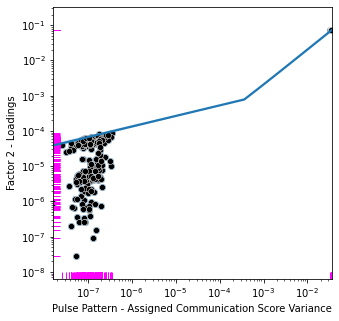

In [429]:
fig, ax = plt.subplots(figsize = (5,5))
colors = sns.color_palette("tab10")[:4]
factor, pattern = 2, 'pulse'
counter = 0
viz_df = res[(res.factor == factor) & (res.assigned_pattern == pattern)]
viz_df = viz_df[(viz_df.loadings < viz_df.loadings.quantile(0.96)) &
       (viz_df.communication_score_variance < viz_df.communication_score_variance.quantile(0.96))]
# viz_df.loadings = np.log10(viz_df.loadings)
# viz_df.communication_score_variance = np.log10(viz_df.communication_score_variance)

sns.regplot(data = viz_df, y = 'loadings', x = 'communication_score_variance', ax = ax,# scatter = False, 
           color = colors[counter])
sns.scatterplot(data = viz_df, y = 'loadings', x = 'communication_score_variance', ax = ax, 
           color = 'black')
sns.rugplot(data = viz_df, y = 'loadings', x = 'communication_score_variance', ax = ax, 
           color = 'magenta')
# sns.lineplot(data = viz_df, y = 'loadings', x = 'communication_score_variance', ax = ax,# scatter = False, 
#            color = colors[counter])
ax.set_ylabel('Factor {} - Loadings'.format(factor))
ax.set_xlabel(pattern.capitalize() + ' Pattern - Assigned Communication Score Variance')
ax.set_xscale('log')
ax.set_yscale('log')